# About the Olist Ecommerce Dataset
Olist is a brazilian startup that helps merchants (sellers in the datasets), particularly brick-and-mortar ones to sell their products in different online and physical marketplaces. Olist also supports them by providing logistics solutions to make sure the selling goes smoothly for the sellers.

The datasets provided are all based on orders placed by users (customers in the datasets) to buy a seller's product.

## Understanding Marketplaces
To contextualize Olist's data, let's put some thought on the basic dynamics of marketplaces. A marketplace connects demand for products or services with its supply. Connecting demand and supply efficiently and effectively is the way marketplaces derive their value. For marketplaces to be successful, they need to grow both their supply and their demand sides to create a positive-loop effect. Which strategy is used to grow the marketplace lies in the hands of its management and should be informed by the needs of the supply and demand players they want to connect. Olist mentions explicitly that their goal is to help small brick and mortar shops sell their products by helping them access both physical marketplaces (retail stores) and online marketplaces (e.g. amazon). They do this by providing a SaaS platform that helps sellers integrate into the marketplaces, place their products and track their performance.

# Exploratory Data Analysis

In order to write a blog post, it's necessary to find a dataset and do a brief exploratory data analysis in order to evaluate what questions are worth asking. The first two datasets to inspect will be `olist_order_items_dataset.csv` which contain the items of a given order and the sellers of the items, and `olist_orders_dataset.csv` which contains the orders and the customers that placed them. The relationship between `olist_orders_dataset.csv` and `olist_order_items_dataset.csv` is one to may i.e. one order can contain many items, keeping this in mind is important when merging the data sets on the column `order_id`. `olist_products_dataset.csv` and `olist_customers_dataset.csv` have additional information about product categories and the location of the customers and their unique IDs respectively and can be joined with the other data sets with the columns `product_id` and `customer_id` respectively.

# Gathering and preparing Data
## Data types and null values
Before starting analysis, we need to check the composition of the datasets, particularly we need to check if the data types of the columns need to be transformed and whether there are any missing values.

In [1]:
# imports only
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # interface to handle dates, will be used for simple date formatting in figures 
import matplotlib.units as munits # we will use the date converter to handle date and datetime units
import seaborn as sns
import statsmodels.tsa.stattools as smtsa
from statsmodels.graphics.tsaplots import plot_acf
import holidays
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot, plot_cross_validation_metric

import dataframe_image as dfi

sns.set(style="darkgrid")

%matplotlib inline

converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

In [2]:
# data sets
oi_df = pd.read_csv('olist_order_items_dataset.csv')
orders_df = pd.read_csv("olist_orders_dataset.csv")
customers_df = pd.read_csv("olist_customers_dataset.csv")
products_df = pd.read_csv("olist_products_dataset.csv")
product_translations_df = pd.read_csv("product_category_name_translation.csv")

### order_items_dataset.csv

In [3]:
oi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


The column `shipping_limit_date` should be transformed to a datetime type if used for analysis.

In [4]:
oi_df.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

The `orders_items`dataset has no null values, makes sense since transactional data only gets generated when an action happens, in this case the transaction is when the order gets approved. It will be more relevant to check if we are missing dimensions of the transactions like `product_category` or `price` for an approved order.

In [5]:
oi_df.tail()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72
112649,fffe41c64501cc87c801fd61db3f6244,1,350688d9dc1e75ff97be326363655e01,f7ccf836d21b2fb1de37564105216cc1,2018-06-12 17:10:13,43.00,12.79


### orders_dataset.csv
These dataset is transactional in nature, here we can see the orders that actually when through for Olist.

In [6]:
orders_df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


Like in the previous data set, timestamps are stored as strings and should be transformed to datetime type for analysis, transformation below.

In [7]:
dtypes_to_keep = [
    'order_id',
    'customer_id',
    'order_status'
]

In [8]:
for col in orders_df.columns.tolist():
    if col in dtypes_to_keep:
        continue
    else:
        orders_df[col] = orders_df[col].astype('datetime64')

orders_df.info();        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


Now we can check the earliest and latest timestamp for the dataset orders.

In [9]:
min_ts, max_ts = orders_df['order_purchase_timestamp'].min(), orders_df['order_purchase_timestamp'].max()
min_ts, max_ts, max_ts - min_ts

(Timestamp('2016-09-04 21:15:19'),
 Timestamp('2018-10-17 17:30:18'),
 Timedelta('772 days 20:14:59'))

We can see that we have two years of data between September 2016 and October 2018.

In [10]:
orders_df.tail()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15
99440,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018-03-08 20:57:30,2018-03-09 11:20:28,2018-03-09 22:11:59,2018-03-16 13:08:30,2018-04-03


In [11]:
orders_df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

We can see that unlike `order_items`, `orders` does contain some missing values for the columns `ordered_approved_at`, `ordered_delivered_carrier_date`, and `ordered_delivered_customer_date`. Having null values for `order_approved_at` makes sense since the payment for the order must go through successfully for it to be approved: two possible issues can be software or other tech issues with the payment processing, as well as card declines due to fraud prevention or lack of funds.

We know that Olist takes cares of the logisitics, we can assume that they use third party logistics companies for this. It's a bit unusual that we would see null values for `order_delivered_carrier_date` which I assume tracks the moment the items of an order were handed to the logistics partners. We also see that `order_delivered_customer_date` has null values. Both cases might be related to orders being lost. Let's briefly check what's the percentage of these assumed lost orders from the total orders.

In [12]:
assumed_lost = orders_df[orders_df['order_delivered_customer_date'].isnull() | orders_df['order_delivered_carrier_date'].isnull()]
assumed_lost['order_id'].count()/ orders_df['order_id'].count() * 100

2.9826731428686357

If the assumption that these are lost orders is right, it still total only 2.98% of the the total orders which for the sake of our analysis will not cause issues.

## Understanding product pricing stratgies from sellers

If sellers continuously change the price of the same item (product_id), we could try to predict price in order to compare the prediction against the history of prices for that product. Before tackling this prediction, it makes sense to check if there is enough price variation for products sold.

In [13]:
oi_df['product_id'].nunique() # number of unique product_ids

32951

In [14]:
product_price_count = oi_df.groupby('product_id')['price'].nunique().sort_values(ascending = False) # series containing the count of price points found for each product_id
product_price_count.describe()

count    32951.000000
mean         1.287002
std          0.893796
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         31.000000
Name: price, dtype: float64

Seems like most products never change prices. This could mean that almost all sellers never change the price of their listed products or that maybe changes/updates to a sellers products produce a new `product_id`. Before checking if the same product is being sold under a different `product_id`, let's check the range of prices for the the product that had the most changes in price.

In [15]:
max_count_product_id = product_price_count.index[0]

In [16]:
max_price_count_df = oi_df[oi_df['product_id'] == max_count_product_id]
max_price_count_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
290,00b8d354b36820e9d6131fd5173c5581,1,437c05a395e9e47f9762e677a7068ce7,bf84056e679dbe9c69929847a40e338f,2018-03-05 03:55:52,50.21,15.10
687,0199115a1cbfc272c5bd53117772a64a,1,437c05a395e9e47f9762e677a7068ce7,f84fa566034f5e8e880a07ec624c56af,2018-03-29 02:27:57,47.65,7.39
1143,02a54d22a5cd81b89c0a40bf9a75d9a4,1,437c05a395e9e47f9762e677a7068ce7,f84fa566034f5e8e880a07ec624c56af,2018-03-26 14:31:50,47.65,7.39
1602,03af60619b8abd880dd136ed837be800,1,437c05a395e9e47f9762e677a7068ce7,bf84056e679dbe9c69929847a40e338f,2018-03-23 17:09:46,59.89,15.30
3406,07b4f186d84795c78fcd70a18b36c256,1,437c05a395e9e47f9762e677a7068ce7,f84fa566034f5e8e880a07ec624c56af,2018-08-21 03:24:52,49.98,15.45


In [17]:
max_price_count_df["price"].describe()

count    155.000000
mean      50.051032
std        2.769751
min       44.980000
25%       47.650000
50%       49.900000
75%       52.600000
max       59.900000
Name: price, dtype: float64

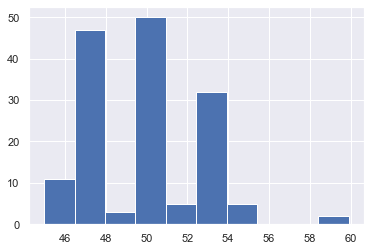

In [18]:
plt.hist(max_price_count_df['price']);

The product with the highest number of price points found had 155 different price points, ranging between 44.98 to 59.90.

## Checking if same product is being sold under a different `product_id`

Before ruling out predicting prices for products, let's see if sellers are selling the same product under a different `product_id`. We can get a sense of this dynamic by counting the number of products offered by the same `seller_id`. This is not 100% accurate but can guide us further.

In [19]:
# number of products sold by seller_id
prods_by_seller_df = oi_df.groupby('seller_id')['product_id'].nunique().sort_values(ascending=False).to_frame(name='unique_product_ids')
prods_by_seller_df

,unique_product_ids
seller_id,
4a3ca9315b744ce9f8e9374361493884,399
cca3071e3e9bb7d12640c9fbe2301306,322
d91fb3b7d041e83b64a00a3edfb37e4f,315
fa1c13f2614d7b5c4749cbc52fecda94,289
7142540dd4c91e2237acb7e911c4eba2,266
...,...
7238f877570096ae403c51898fa64566,1
723a46b89fd5c3ed78ccdf039e33ac63,1
72431a818f97fe6ab9c81eee3e297e54,1


In [20]:
prods_by_seller_df.describe()

,unique_product_ids
count,3095.000000
mean,11.130210
std,24.473252
min,1.000000
25%,2.000000
50%,4.000000
75%,10.000000
max,399.000000


We can see that the 75th percentile has only 10 unique products, so we can safely assume that with the available data set, we cannot assume that sellers have several product IDs for the same product. Let's see the kernel density plot for sellers with less than 10 unique product IDs.

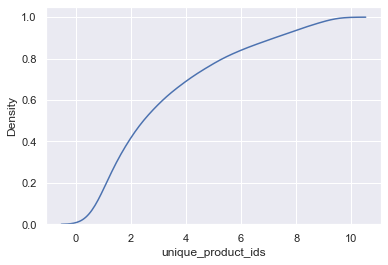

In [21]:
sns.kdeplot(data=prods_by_seller_df[prods_by_seller_df['unique_product_ids'] < 10], x='unique_product_ids', cumulative=True);

We can see that around 70% of the values correspond to less that 4 unique products for a seller.  I will assume that changes to products (updates, etc.) do not change the `product_id`. Given the low variability in prices and products sold by sellers, I won't be pursuing the prediction of a product's price.

## Understanding Olist as a marketplace: demand and supply
With two years of data, understanding the dynamics of Olist as a marketplace over time might be more relevant. We know that Olist has a demand and a supply side, the customers and sellers respectively. Let's see if the `olist_products_dataset.csv` data can inform us about the supply side independently from the orders.

In [22]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


Sadly, the products data does not have information about when a product was first made available for purchase. This is relevant because it would have allowed us to analyze the relationship between a supply (product availability) and demand (purchasing of the products). It seems that the product information we have is only related to purchased items which makes it fully derived and dependent from the demand side.

# Time series analysis
Even though a supply-demand analysis does not seem possible, we still have two years of orders which means that we can try to identify patterns in the time series' we have available.

## Data wrangling
To not have too much granularity on the orders time series, I will aggregate the orders to a daily level. In addition to the number of orders, it might be interesting to see the count of products, sellers and customers related to these orders, so before doing the orders aggregation, I need to join the the other data sets with the orders one.

We know that the highest cardinality lies in the orders and items dataset but we are also interested the number of unique customers related to the orders. In order to add the customer information, we need to left join the orders data with orders items to keep the highest cardinality and add the `customer_id` column that is found in the orders data set. `customer_id` is not the unique identifier for a customer, if we want the unique count of customers related to the orders placed we also need to join the customers data set.

Lastly, analyzing which product categories contribute the most to the orders is a core business question, so we need to join the products data set as well.

In [23]:
# doing SQL style joins to add missing dimensions to orders
orders_items_joined_df = pd.merge(left=oi_df, right=orders_df[['order_id', 'customer_id', 'order_approved_at']], how='left', on='order_id')
# osc stands for orders, sellers, customers
osc_df = pd.merge(left= orders_items_joined_df, right=customers_df[['customer_id', 'customer_unique_id', 'customer_city']], how='left', on='customer_id')
osc_df = pd.merge(left= osc_df, right=products_df[['product_id', 'product_category_name']], how='left', on='product_id')
osc_df = pd.merge(left= osc_df, right=product_translations_df, how='left', on='product_category_name')
osc_df['product_category_name'] = osc_df['product_category_name_english']
osc_df = osc_df.drop(columns=['product_category_name_english'])

In [24]:
oi_df.shape[0] == osc_df.shape[0] # order_items has the largest number of rows, so the new osc dataframe should have the same number of rows

True

In [25]:
osc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               112650 non-null  object        
 1   order_item_id          112650 non-null  int64         
 2   product_id             112650 non-null  object        
 3   seller_id              112650 non-null  object        
 4   shipping_limit_date    112650 non-null  object        
 5   price                  112650 non-null  float64       
 6   freight_value          112650 non-null  float64       
 7   customer_id            112650 non-null  object        
 8   order_approved_at      112635 non-null  datetime64[ns]
 9   customer_unique_id     112650 non-null  object        
 10  customer_city          112650 non-null  object        
 11  product_category_name  111023 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), 

Now that we have joined the data, let's drop unnecessary columns and check for nulls.

In [26]:
osc_df = osc_df.drop(columns=['shipping_limit_date', 'freight_value', 'customer_id'])

In [27]:
osc_df.isnull().sum()

order_id                    0
order_item_id               0
product_id                  0
seller_id                   0
price                       0
order_approved_at          15
customer_unique_id          0
customer_city               0
product_category_name    1627
dtype: int64

We see that we have 1603 products for which no product category was found, let's briefly have a look.

In [28]:
osc_df[osc_df['product_category_name'].isnull()]

,order_id,order_item_id,product_id,seller_id,price,order_approved_at,customer_unique_id,customer_city,product_category_name
123,0046e1d57f4c07c8c92ab26be8c3dfc0,1,ff6caf9340512b8bf6d2a2a6df032cfa,38e6dada03429a47197d5d584d793b41,7.79,2017-09-26 15:49:17,b0efd7adeb04d15b16edaedd11215d40,sao paulo,NaN
125,00482f2670787292280e0a8153d82467,1,a9c404971d1a5b1cbc2e4070e02731fd,702835e4b785b67a084280efca355756,7.60,2017-02-14 03:42:56,d4c784ecad19dfe09e63ffaf9ada82a3,juiz de fora,NaN
132,004f5d8f238e8908e6864b874eda3391,1,5a848e4ab52fd5445cdc07aab1c40e48,c826c40d7b19f62a09e2d7c5e7295ee2,122.99,2018-02-28 09:29:25,17726716a98c98a7806b43a789820245,corumba,NaN
142,0057199db02d1a5ef41bacbf41f8f63b,1,41eee23c25f7a574dfaf8d5c151dbb12,e5a3438891c0bfdb9394643f95273d8e,20.30,2018-01-20 09:07:51,9a5b186787a143669398bd8083720c21,sinop,NaN
171,006cb7cafc99b29548d4f412c7f9f493,1,e10758160da97891c2fdcbc35f0f031d,323ce52b5b81df2cd804b017b7f09aa7,56.00,2018-02-17 14:35:28,d5faae3f913e775994e53068992969b5,brasilia,NaN
...,...,...,...,...,...,...,...,...,...
112306,ff24fec69b7f3d30f9dc1ab3aee7c179,1,5a848e4ab52fd5445cdc07aab1c40e48,c826c40d7b19f62a09e2d7c5e7295ee2,122.99,2018-01-27 02:40:12,ae76d876d1067aa49fa661723d824ed5,jaragua do sul,NaN
112333,ff3024474be86400847879103757d1fd,1,f9b1795281ce51b1cf39ef6d101ae8ab,3771c85bac139d2344864ede5d9341e3,39.90,2017-11-14 03:55:39,7ae8e196478928ab8223458a90681d26,campinas,NaN
112350,ff3a45ee744a7c1f8096d2e72c1a23e4,1,b61d1388a17e3f547d2bc218df02335b,07017df32dc5f2f1d2801e579548d620,139.00,2017-05-04 10:15:19,367879109f7a4aac09ac25b29d133d3a,volta redonda,NaN
112438,ff7b636282b98e0aa524264b295ed928,1,431df35e52c10451171d8037482eeb43,6cd68b3ed6d59aaa9fece558ad360c0a,49.90,2018-02-18 15:35:35,3dceeb3d4179741a2989416284356e63,brasilia,NaN


Since we will be mostly focused on order counts to start with, we don't have a strong reason to drop the missing product category values for now. Let's relabel them to "missing".

In [29]:
osc_df['product_category_name'] = osc_df['product_category_name'].fillna('missing')

Pandas supports datetime indexes and makes it very simple to create plots, let's used the column `order_approved_at` as the index timestamp. To generate unique counts of orders, customers, products and sellers we can use the resample and nunique methods of a pandas dataframe with datetime index.

In [30]:
# since approved orders are the ones driving revenue, we will set this columns as the index
osc_df = osc_df.set_index('order_approved_at')
osc_daily = osc_df[['order_id', 'product_id', 'seller_id', 'customer_unique_id']].resample(rule='D').nunique()
osc_daily

,order_id,product_id,seller_id,customer_unique_id
order_approved_at,,,,
2016-09-15,1,1,1,1
2016-09-16,0,0,0,0
2016-09-17,0,0,0,0
2016-09-18,0,0,0,0
2016-09-19,0,0,0,0
...,...,...,...,...
2018-08-30,0,0,0,0
2018-08-31,0,0,0,0
2018-09-01,0,0,0,0


In [31]:
osc_daily.index

DatetimeIndex(['2016-09-15', '2016-09-16', '2016-09-17', '2016-09-18',
               '2016-09-19', '2016-09-20', '2016-09-21', '2016-09-22',
               '2016-09-23', '2016-09-24',
               ...
               '2018-08-25', '2018-08-26', '2018-08-27', '2018-08-28',
               '2018-08-29', '2018-08-30', '2018-08-31', '2018-09-01',
               '2018-09-02', '2018-09-03'],
              dtype='datetime64[ns]', name='order_approved_at', length=719, freq=None)

We have 719 days with counts. Let's check that there are days where more than one order was placed.

In [32]:
osc_daily[osc_daily['order_id'] > 1]

,order_id,product_id,seller_id,customer_unique_id
order_approved_at,,,,
2016-10-04,19,19,16,19
2016-10-05,10,14,8,10
2016-10-06,108,102,69,108
2016-10-07,57,58,47,56
2016-10-08,26,28,22,26
...,...,...,...,...
2018-08-25,81,85,75,81
2018-08-26,70,71,66,70
2018-08-27,64,64,59,64


## Business Questions
Now that we have a simple time series of unique orders, products, sellers and customers, we can think of relevant business questions that can be answered.

1. Which product categories contribute the most to total products purchased?
2. From which cities are most products being bought from?
2. Is there any seasonality to the number of orders placed?

### Histograms

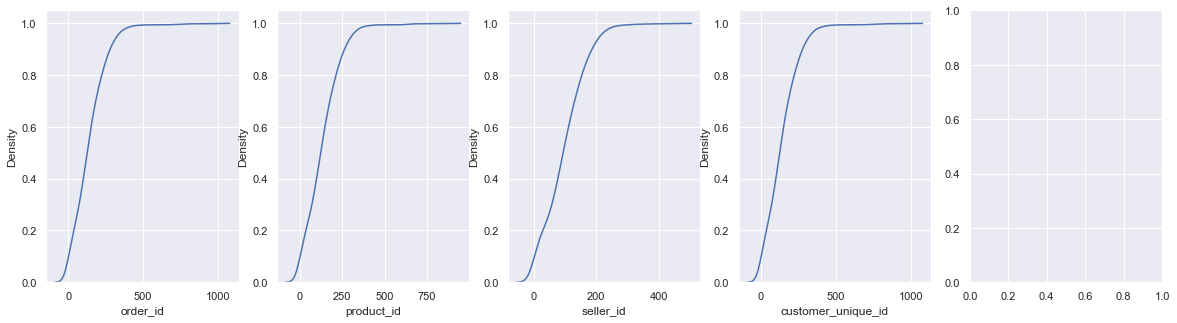

In [33]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for col, ax in zip(osc_daily.columns.tolist(), axs):
    sns.kdeplot(data=osc_daily, x=col, cumulative=True, ax=ax)

We can see that the unique counts of orders, products, sellers and customers have a very similar cumulative distribution function. We can see from it that all of them skew to the right and in the case of daily unique orders, it reached 90% at around 400 orders but reached 100% at over thousand orders.

### Simple time series plot
Before digging deeper into the contribution of each category to orders, let's have a look a the time series for unique products and orders.

Text(0, 0.5, 'Count')

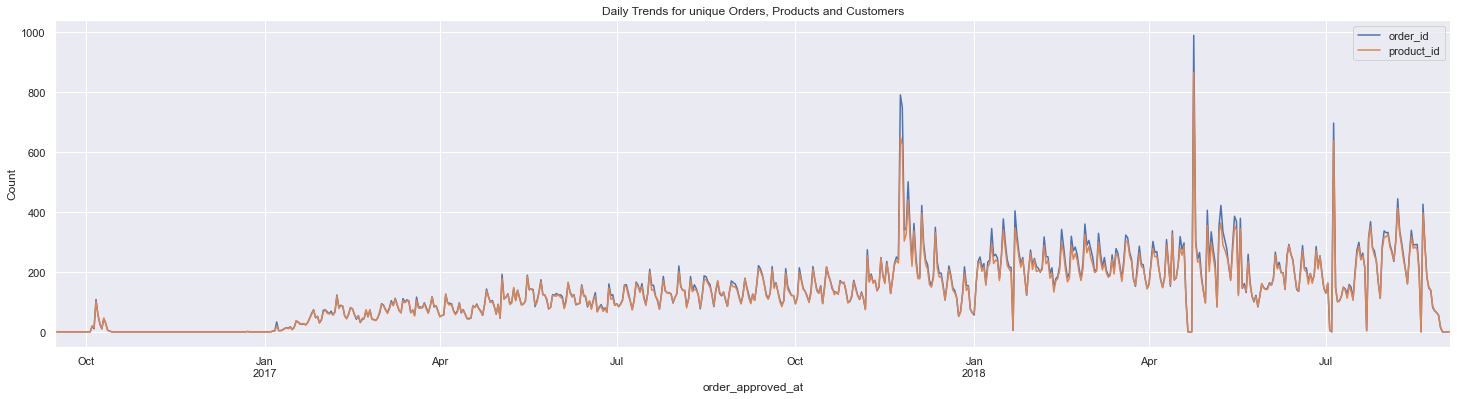

In [34]:
ax = osc_daily[['order_id', 'product_id']].plot(figsize=(25,6))
ax.set_title('Daily Trends for unique Orders, Products and Customers')
ax.set_ylabel('Count')

We can see that the unique daily count of product IDs and order IDs follow the same trends, this is a strong indication that the the products data set has been derived from products that had orders and it's not indicating product availability.

We can also see that between October 2016 and January 2017 there are no orders. I will be removing this interval from the dataset. 

It looks like there is steady but small upwards trend in the first 3 quarters of 2017 with a big spike in November or December of 2017. From the big spike at the end of 2017 onwards, daily orders oscillate much more heavily and it's hard to realize whether there is any trend at all. There are two additional big spikes in the second and third quarter of 2018.

In [35]:
osc_df = osc_df[(osc_df.index >= '2017-01-01') & (osc_df.index < '2018-09-01')]
print(osc_df.index.min(), osc_df.index.max())

2017-01-05 12:10:17 2018-08-29 15:10:26


In [36]:
osc_daily = osc_daily[(osc_daily.index >= '2017-01-01') & (osc_daily.index < '2018-09-01')]
print(osc_daily.index.min(), osc_daily.index.max())

2017-01-01 00:00:00 2018-08-31 00:00:00


#### Averages

It's hard to follow a trend with all the peaks and troughs, let's a rolling mean to smoothen the graphs and visualize a trend.

In [37]:
osc_rolling_mean = osc_daily.rolling(7).mean()
osc_rolling_mean.columns = [col + '_window_mean' for col in osc_rolling_mean.columns.tolist()]
osc_rolling_mean

,order_id_window_mean,product_id_window_mean,seller_id_window_mean,customer_unique_id_window_mean
order_approved_at,,,,
2017-01-01,NaN,NaN,NaN,NaN
2017-01-02,NaN,NaN,NaN,NaN
2017-01-03,NaN,NaN,NaN,NaN
2017-01-04,NaN,NaN,NaN,NaN
2017-01-05,NaN,NaN,NaN,NaN
...,...,...,...,...
2018-08-27,139.000000,139.285714,114.000000,138.857143
2018-08-28,105.428571,106.285714,89.000000,105.285714
2018-08-29,81.428571,82.857143,69.571429,81.428571


Since we will probaly want to visualize daily counts and their rolling window means together, it's a good time to write a function that will calculate the following for a give numeric column 1) the window mean, where the window value is a function argument, 2) join the results dataframes, 3) create the axes and plot the values

In [38]:
def resample_df(df, count_columns, aggregation_level, aggregation_function, set_index=False, **kwargs):
    """
    returns a dataframe with daily unique counts
    
    df: dataframe with at least one datetime column to use a datetime index
    count_columns: list of columns to resample
    aggregation_level: The offset string or object representing target conversion e.g. 'D' for day, 'M' for month
    aggregation_function: function to use passed as a string e.g. 'sum', "count", "nunique"
    if set_index=True, pass a keyword argument dt_column=column to be set as the index
    """

    if set_index and ('dt_column' in kwargs):
        try:
            df = df.set_index(kwargs['dt_column'])
        except 'TypeError':
            df[kwargs['dt_column']] = dfdf[kwargs['dt_column']].astype('datetime64')
    
    return df[count_columns].resample(rule=aggregation_level).agg(aggregation_function)
        

In [39]:
def get_ew_mean(df, column, span, join=True):
    """
    returns a dataframe with column and the exponentially weighted mean applied to the column
    
    df: dataframe with numeric values, index should be of type datetime, daily level
    column: column to apply the exponentially weighted mean
    """
    if join:
        suffix = "_" + str(span) + "ew_mean"
        return df[column].to_frame().join(df[column].ewm(span=span).mean().to_frame(name=column + suffix))
    else:
        return df[column].ewm(span=span).mean().to_frame(name=column + suffix)

In [40]:
def get_rolling_mean(df, column, window, join=True):
    """
    returns a dataframe with column the moving average (rolling mean) applied to the column
    
    df: dataframe with numeric values, index should be of type datetime, daily level
    column: column to apply the moving average
    """
    if join:
        suffix = "_" + str(window) + "day_mean"
        return df[column].to_frame().join(df[column].rolling(window).mean().to_frame(name=column + suffix))
    else:
        return df[column].to_frame().rolling(window).mean().to_frame(name=column + suffix)

In [41]:
def mean_fetcher(df, column, window, means, join=True):
    """
    calls one or many functionas that calculate a specific mean, returns the result of the function
    
    df: dataframe with numeric values
    column: column in the dataframe on which to calculate the mean
    means: list of means to calculate, valid are "rolling" and "ew"
    """
    
    means_dict = {
        'rolling': get_rolling_mean,
        'ew': get_ew_mean
    }
    
    result_dfs = [means_dict[mean](df, column, window, join) for mean in means if mean in means_dict]
    
    if len(result_dfs) == 1:
        return result_dfs[0]
    else:
        return result_dfs[0].join(result_dfs[1].drop(columns=[column]), lsuffix="_" + means[0], rsuffix="_" + means[1])
    

In [42]:
def plot_cols(df, columns, y_label, title, xlim=None, filename=None, **kwargs):
    """
    returns a list of figures with time series plots
    
    df: dataframe with numeric values, index should be of type datetime, daily level
    columns: list of columns within df for which to plot the time series, strings
    title: plot title, string
    y_label: y axis label, string
    kwargs: used to calculate a mean based on a window e.g. {'means': ['rolling', 'ew'], 'window'=7}
        keys for kwargs: 'means' and 'window'
        keys' values:
            for 'means': a list of means to use, available are 'rolling' and 'ew' (exponentially weighted)
            for 'window': integer, interval for which to calculate the mean chosen
    """
    
    fig, axs = plt.subplots(len(columns), 1, figsize=(25, 8 * len(columns)), sharex=False, constrained_layout=True)
    
    try:
        len(axs)
    except TypeError:
        axs = [axs]
    
    column_dfs = []
    for col in columns:
        if 'window' in kwargs:
            column_dfs.append(mean_fetcher(df, col, **kwargs, join=True ))
        else:
            column_dfs.append(df[col].to_frame(name=col))
    
    for df, ax in zip(column_dfs, axs):
        for col, style in zip(df.columns.tolist(), ['-', '-.', '--']):
            ax.plot(df.index, df[col], linestyle=style, label=col)
            labels = ax.get_xticklabels()
            plt.setp(labels, rotation=45, horizontalalignment='center')
            ax.set(ylabel=y_label)
            ax.legend(loc="upper left")
        if xlim:
            ax.set_xlim(*xlim)

    fig.suptitle(title)
    if filename:
        plt.savefig(filename)

In [43]:
orders_daily = osc_daily['order_id']
orders_daily

order_approved_at
2017-01-01     0
2017-01-02     0
2017-01-03     0
2017-01-04     0
2017-01-05     3
              ..
2018-08-27    64
2018-08-28    56
2018-08-29    15
2018-08-30     0
2018-08-31     0
Name: order_id, Length: 608, dtype: int64

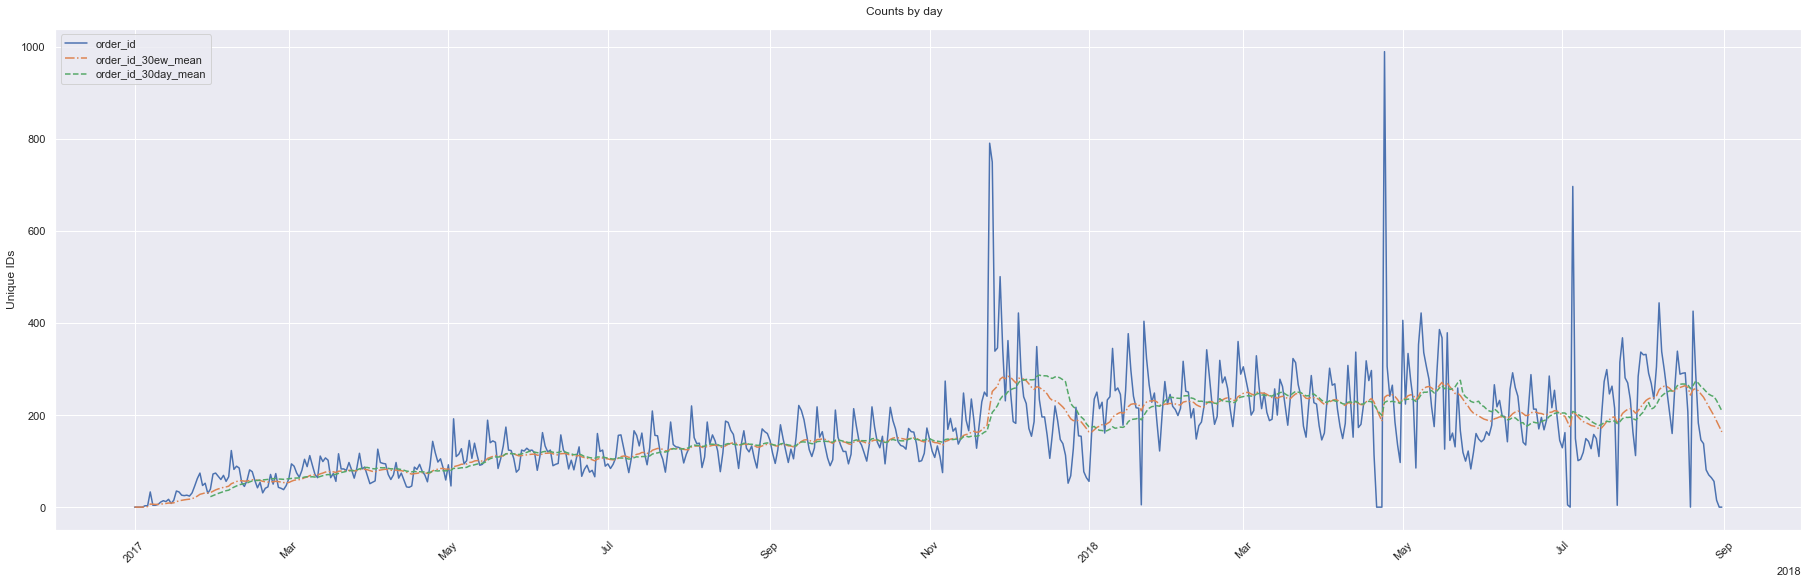

In [44]:
plot_cols(osc_daily, ['order_id'], "Unique IDs" , "Counts by day", filename='graphs_tables/orders_daily_plot.png', window=30, means=['ew', 'rolling'])

The above graph shows the unique count of order IDs and two averages, the orange line is an exponentially weigthed average for a 30 day span and the green line is 30 day simple moving average. Through these averaged we can definitely better recognize the steady growth through 2017 but also no growth in the first two quarters of 2018 and then a dip in the middle of the 3rd quarter of 2018.

Having analyzed the basic trends and orders, let's refocus on our business questions.

### Question 1: Product Category Share from total sold products
Let's check the share of each product category for the full data set and later on see the evolution over time. We know that an order can contain one or more items from the same product category, so we need to count the number of products sold per day per category.

In [45]:
product_cat_daily_df = osc_df.groupby([osc_df.index.date,'product_category_name'])['product_id'].count().reset_index(level=1)
product_cat_daily_df.index = pd.to_datetime(product_cat_daily_df.index)
product_cat_daily_df

,product_category_name,product_id
2017-01-05,fashion_bags_accessories,1
2017-01-05,furniture_bedroom,1
2017-01-05,garden_tools,1
2017-01-06,consoles_games,1
2017-01-06,health_beauty,1
...,...,...
2018-08-29,kitchen_dining_laundry_garden_furniture,2
2018-08-29,party_supplies,1
2018-08-29,sports_leisure,1
2018-08-29,toys,1


In [46]:
def get_share_of_count(df, group_column, count_column, agg_function, new_column_name):
    """
    group_column: column of df to group by
    count_coumn: column to count unique values
    agg_funtion: function to count values
    new_column_name: column name of the aggregation
    """
    
    count_df = df.groupby(group_column)[count_column].agg(agg_function).sort_values(ascending=False).to_frame(name=new_column_name)
    count_df['share_from_total'] = count_df / count_df.sum()
    count_df['cummulative_share'] = count_df['share_from_total'].cumsum()
    return count_df

In [47]:
product_category_counts = get_share_of_count(product_cat_daily_df, 'product_category_name', 'product_id', 'sum', 'total_product_ids')
dfi.export(product_category_counts[:10], 'graphs_tables/top10_product_categories_products_table.png')

In [48]:
len(product_category_counts.index)

72

We have 72 categories for which a product was shipped as part of an order any given point in time. We can also see that the top 10 categories make up 63% of the total products sold during the two years of data. 

The top category is `bed_bath_table`, followed by `health_beauty` and `sports_leisure`. Have these top categories always contributed the same share of products sold or has this changed over time?

In [49]:
top_categories = (product_category_counts[product_category_counts['cummulative_share'] <= 0.64]).index.tolist()
top_categories

['bed_bath_table',
 'health_beauty',
 'sports_leisure',
 'furniture_decor',
 'computers_accessories',
 'housewares',
 'watches_gifts',
 'telephony',
 'garden_tools',
 'auto']

In [50]:
products_monthly = product_cat_daily_df['product_id'].to_frame().resample(rule='M').sum()
products_monthly.columns = ['monthly_total_products']
products_monthly

,monthly_total_products
2017-01-31,908
2017-02-28,1931
2017-03-31,3022
2017-04-30,2655
2017-05-31,4130
2017-06-30,3602
2017-07-31,4464
2017-08-31,4937
2017-09-30,4852
2017-10-31,5275


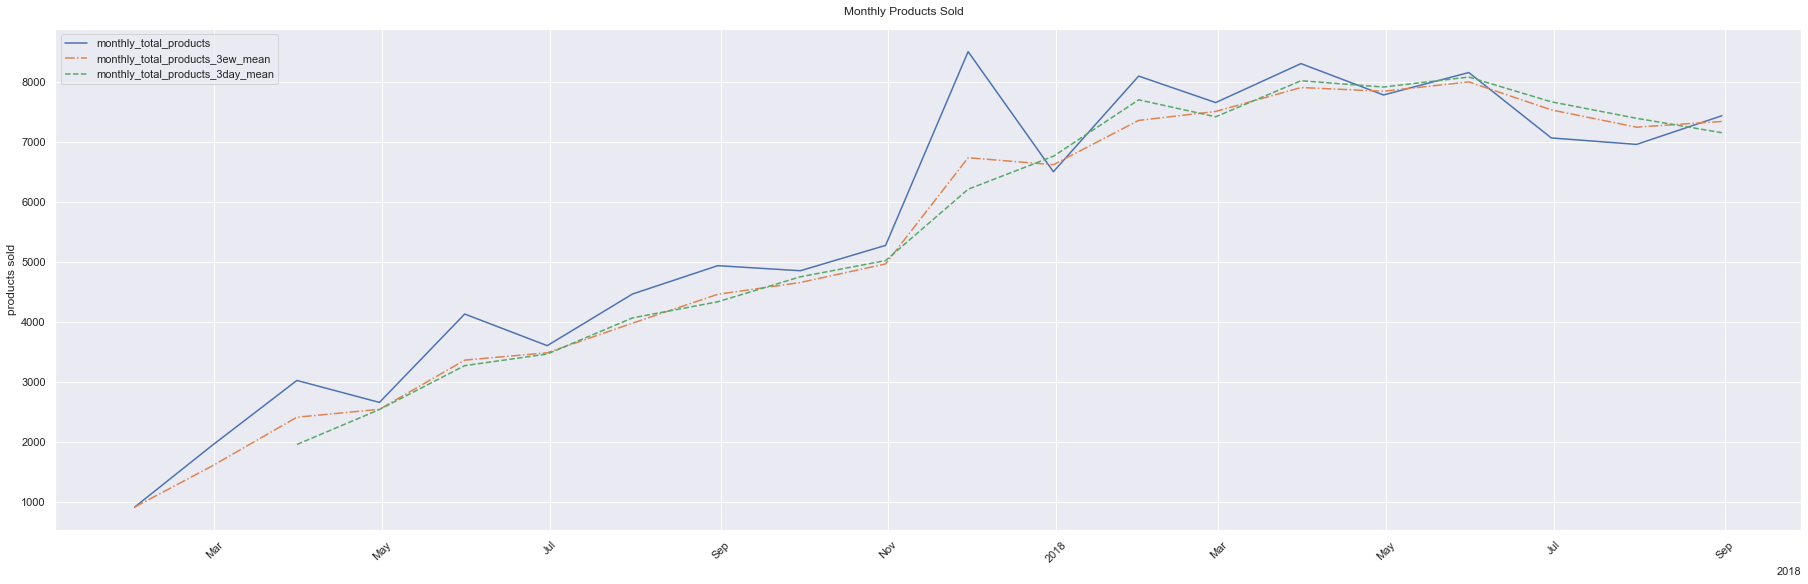

In [51]:
plot_cols(products_monthly, ['monthly_total_products'], "products sold", 'Monthly Products Sold', filename='graphs_tables/monthly_products_plot.png', window=3, means=['ew', 'rolling'])
plt.savefig('graphs_tables/monthly_products_plot.png')

From the above graph above, we can see an upwards trend in products sold until the middle of the second quarter of 2018 (around April), afterwards the growth seems to slow down and around June 2018 it looks like the number of monthly products sold starts to go down. With the absolute values for products sold plotted, we can now see the the monthly shares by category.

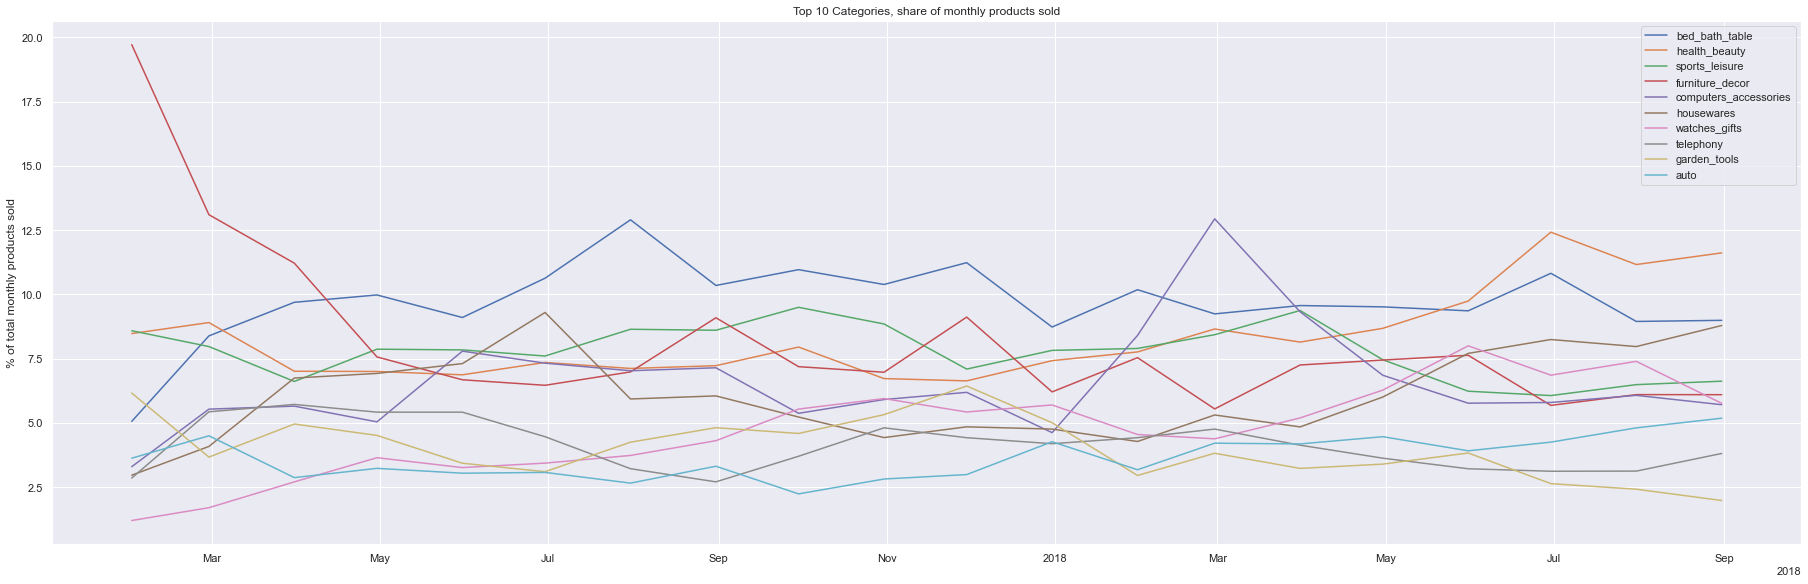

In [52]:
products_monthly_copy = products_monthly.copy(deep=True)
fig, ax = plt.subplots(1,1, figsize=(25,8), constrained_layout=True)
for cat in top_categories:
    cat_df = product_cat_daily_df[product_cat_daily_df['product_category_name']==cat]
    cat_monthly_df = resample_df(cat_df,['product_id'], aggregation_level='M', aggregation_function='sum')
    cat_count_column = f"{cat}_monthly_products"
    cat_monthly_df.columns = [cat_count_column]
    products_monthly_copy = products_monthly_copy.merge(cat_monthly_df, how='left', left_index=True, right_index=True)
    cat_monthly_share = (cat_monthly_df[cat_count_column] / products_monthly_copy['monthly_total_products']) * 100
    products_monthly_copy[f"{cat}_monthly_products_share"] = cat_monthly_share
    cat_monthly_share = pd.DataFrame(cat_monthly_share, columns=[f"{cat}_monthly_products_share"])
    ax.plot(cat_monthly_share.index, cat_monthly_share[f"{cat}_monthly_products_share"], label=cat)

ax.set(ylabel='% of total monthly products sold', title='Top 10 Categories, share of monthly products sold')
plt.legend()
#     plot_cols(cat_monthly_share, cat_monthly_share.columns.to_list(), "% from total", f"Category = {cat} Monthly Share from Total Products Sold")

In [ ]:
products_monthly_copy = products_monthly.copy(deep=True)
for cat in top_categories:
    cat_df = product_cat_daily_df[product_cat_daily_df['product_category_name']==cat]
    cat_monthly_df = resample_df(cat_df,['product_id'], aggregation_level='M', aggregation_function='sum')
    cat_count_column = f"{cat}_monthly_products"
    cat_monthly_df.columns = [cat_count_column]
    products_monthly_copy = products_monthly_copy.merge(cat_monthly_df, how='left', left_index=True, right_index=True)
    cat_monthly_share = (cat_monthly_df[cat_count_column] / products_monthly_copy['monthly_total_products']) * 100
    products_monthly_copy[f"{cat}_monthly_products_share"] = cat_monthly_share
    cat_monthly_share = pd.DataFrame(cat_monthly_share, columns=[f"{cat}_monthly_products_share"])
    plot_cols(cat_monthly_share, cat_monthly_share.columns.to_list(), "% from total", f"Category = {cat} Monthly Share from Total Products Sold")

It's a bit hard to follow the trends with 10 separate line plots, I'll try a single matplotlib ax in the form of a heatmap with the months as y labels, the categories as x labels, and the monthly share to total orders as the value.

In [ ]:
products_monthly_copy.info()

In [ ]:
try:
    products_monthly_copy.index = products_monthly_copy.index.strftime('%Y-%m')
except AttributeError:
    pass
    
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(products_monthly_copy.drop(columns=['monthly_total_products']).filter(like='_share', axis=1), yticklabels=True, annot=True, ax=ax)
plt.savefig("graphs_tables/top10_categories_monthly_share_products_heatmap.png")
;

From the heatmap we can see that the top category for the two years of data `bed_bath_table` consistently takes around 8% to 10% of monthly products sold. `health_beauty` has an upwards trend starting in the lower 7% and ending the last months of the series above 10% from total monthly sold products, overtaking `bed_bath_table` as the top category for these months. Lastly, we can see that the categories `housewares` and `watches_gifts` had an upwards trends for their share of total products sold towards the end of the series, while `sports_leisure` and `furniture_decor` had a downwards trend as time went on.

### Question 2: Customer City share from total sold products
Let's use the same workflow as for product category to see where products sold are being bought from within Brazil.

In [ ]:
customer_city_daily_df = osc_df.groupby([osc_df.index.date,'customer_city'])['product_id'].count().reset_index(level=1)
customer_city_daily_df.index = pd.to_datetime(customer_city_daily_df.index)
customer_city_daily_df

In [ ]:
customer_city_product_counts = get_share_of_count(customer_city_daily_df, 'customer_city', 'product_id', 'sum', 'total_product_ids')
dfi.export(customer_city_product_counts[:10], 'graphs_tables/top10_cities_products_table.png')
customer_city_product_counts[:10]

In [ ]:
top_cities = (customer_city_product_counts[customer_city_product_counts['cummulative_share'] <= 0.36]).index.tolist()
city_products_monthly_copy = products_monthly.copy(deep=True)
for city in top_cities:
    city_df = customer_city_daily_df[customer_city_daily_df['customer_city']==city]
    city_monthly_df = resample_df(city_df,['product_id'], aggregation_level='M', aggregation_function='sum')
    city_count_column = f"{city}_monthly_products"
    city_monthly_df.columns = [city_count_column]
    city_products_monthly_copy = city_products_monthly_copy.merge(city_monthly_df, how='left', left_index=True, right_index=True)
    city_monthly_share = (city_monthly_df[city_count_column] / city_products_monthly_copy['monthly_total_products']) * 100
    city_products_monthly_copy[f"{city}_monthly_products_share"] = city_monthly_share
    city_monthly_share = pd.DataFrame(city_monthly_share, columns=[f"{city}_monthly_products_share"])
#     plot_cols(city_monthly_share, city_monthly_share.columns.to_list(), "% from total", f"City = {city} Monthly Share from Total Products Sold")

In [ ]:
try:
    city_products_monthly_copy.index = city_products_monthly_copy.index.strftime('%Y-%m')
except AttributeError:
    pass
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(city_products_monthly_copy.drop(columns=['monthly_total_products']).filter(like='_share', axis=1), yticklabels=True, annot=True, ax=ax)
plt.savefig("graphs_tables/top10_cities_monthly_share_products_heatmap.png")
;

In terms of the share from total monthly products sold per city, we can see that as the number of products sold increased (see figue 'Monthly Products Sold'), the share of Sao Paolo increased as well, meaning that most of the growth in products sold came from customers in Sao Paolo. Rio de Jairo has a more or less constant share of between 6% to 8%. All other cities, the long tail, seem to have a mothly share of 2% or less.

In [ ]:
customer_city_monthly_df = osc_df.groupby([osc_df.index.year, osc_df.index.month, 'customer_city'])['product_id'].count()
customer_city_monthly_df.index = customer_city_monthly_df.index.set_names(['year', 'month', 'customer_city'])
monthly_totals = customer_city_monthly_df.groupby(level=[0,1]).sum()
pcts = customer_city_monthly_df / monthly_totals
customer_city_monthly_df = customer_city_monthly_df.to_frame()
customer_city_monthly_df['monthly_share'] = pcts
customer_city_monthly_df
# customer_city_monthly_df = customer_city_monthly_df.reset_index()

In [ ]:
len(customer_city_monthly_df.index.unique(level=2)) # number of cities with at least one product purchased

In [ ]:
dfi.export(customer_city_monthly_df['product_id'].describe().to_frame(), 'graphs_tables/city_product_count_summary_statistics_table.png')
customer_city_monthly_df['product_id'].describe().to_frame(name='product_count')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 8))
sns.kdeplot(data=customer_city_monthly_df, x='product_id', cumulative=True, ax=ax)
plt.savefig("graphs_tables/city_products_count_cdf.png")

From the summary statistics above, we can see that the median monthly purchased products per city is 1, which means that most cities have very few monthly purchased items. That shows that Olist has only significant demand in Sao Paolo and Rio de Janeiro. Neverthless, these two cities have never been accumulated more than 30% of total products purchased in a month, meaning that for Olist the longtail of smaller cities still represents the higher proportion of products purchased.

### Question 3: Seasonality
Let's now answer the last question: are there any days or months in which more orders are placed? Let's start by having a look again at the daily orders graph and the simple moving average and exponentially weighted average.

In [ ]:
plot_cols(osc_daily, ['order_id'], "Unique IDs" , "Counts by day", window=30, means=['ew', 'rolling'])

#### Dickey-Fuller Test
The Dickey-Fuller allows us to check whether the time series is stationary or not. Briefly explained, a time series is stationary if it's probability distribution does not change over time. When a time series trends upwards or downwards, it is not stationary. When a time series is not stationary, lagged values of the time series can provide relevant information in predicting future change of the series. The null hypothesis for the Dickey-Fuller test is that the time series is **not stationary**, when the test returns a p-value above 5%, we have failed to reject the null hypothesis with statistical significance, and we can assume that the time series has a trend.

From the above graph, it seems like the number of orders placed is not stationry until around November 2017 with an upwards trend but it's hard to know if there is any trend at all afterwards, let's check the p-values of the Dickey-Fuller test for these two ranges.

In [ ]:
results = smtsa.adfuller(orders_daily[:'2017-12-01'])
results[1]

In [ ]:
results = smtsa.adfuller(orders_daily['2017-12-01':])
results[1]

In [ ]:
ranges = [['2017-01-01', '2017-12-01'], ['2017-12-01', '2018-10-01']]
pvalues = [
    smtsa.adfuller(orders_daily[rnge[0]:rnge[1]])[1]
    for rnge in ranges
]
pval_col = {'pvalues': pvalues}
index = pd.MultiIndex.from_arrays(ranges, names=('start', 'end'))
dfuller_pvals_df = pd.DataFrame(data=pval_col, index=index)
dfi.export(dfuller_pvals_df, "graphs_tables/dfuller_pvals_table.png")
dfuller_pvals_df

Until December 2017, according to the Dickey-Fuller test, the times series is not stationary and it clearly has a trend upwards. The p-value is 98% for this time range. The rest of the time series seems to be stationary, the test confirming the null hypothesis with a very low p-value. Let's plot p-values for the interval ranges of 3 months to see how consistent the above results are.

In [ ]:
pvals = []
day_ranges = []
step = 90
for i in range(0,len(orders_daily + 1), step):
    print(orders_daily[i:i + step].index.min(), orders_daily[i:i + step].index.max())
    results = smtsa.adfuller(orders_daily[i:i + step])
    pvals.append(results[1])
    day_ranges.append(i + step)
#     day_ranges.append(f"{i} : {i + step}")
    

fig, ax = plt.subplots(1,1, figsize=(10, 5))    
ax.stem(day_ranges, pvals, basefmt='b', use_line_collection=True)
ax.axhline(y=0.05, color='r')
ax.set(xlabel='Upper Day Range', ylabel='p-value', title='Dickery-Fuller p-values for 30 day intervals');

#### Autocorrelation
In time series analysis, it's important to understand whether a value of your series is related to previous values of the same series. To do so, we use an interval value called a lag, to create a shifted time series that is then compared to the original. The autocorrelation is the correlation of a time series with itself at a range of lag times. This test also allows us to get an idea of whether there is seasonality in a time series since. In a time series with weekly seasonality, we expect higher correlations for 7 day lags. Below I will be plotting the correlation values of the times series lagged by different values, from 0 to 50 days.

In [ ]:
orders_daily = osc_daily['order_id']
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_acf(orders_daily, ax=ax, fft=True, lags=50)
ax.set(xlabel='Lags', ylabel='Correlation', title='Autocorrelation Function')
plt.savefig("graphs_tables/daily_orders_autocorrelation_plot.png")
;

The blue shaded area represents the confidence interval. For values outside of the blue area, the correlation has a statistical significance of less than 5% i.e. it's not a fluke. As expected, we can see that beyond a lag of zero days which yields 100% correlation as expected, a lag of 7 days has the highest correlation at 60%. As we increase the lag value, the correlation decreases but we can see that multiples of 7 show as peaks. This means that for example two Tuesdays separated by a 2 week period are still correlated but less than two Tuesdays separated by a one week period.

#### Weekday time series
Having provided some time series related statistics, let's plot the evolution of daily orders over time of each day of the week to find if one day is consistently higher than the others.

In [ ]:
orders_daily_df = orders_daily.to_frame()
orders_daily_df['weekday_name'] = orders_daily_df.index.day_name()
orders_daily_df.info()

In [ ]:
weekdays = orders_daily_df['weekday_name'].unique()
fig, ax = plt.subplots(1,1, figsize=(20,8))
for day in weekdays:
#     print(day)
    day_df = orders_daily_df[orders_daily_df['weekday_name'] == day]
    ax.plot(day_df.index, day_df['order_id'].ewm(span=4).mean(), label=day)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='center')
ax.set(xlabel='Months', ylabel='Unique Order IDs', title='Weeday Trends')
plt.legend()
plt.savefig("graphs_tables/weekday_orders_plot.png")
;

In the above graph, I used an exponentially weighted average of 4 units i.e. for each weekday, we have a separate line, and each of them takes the past 4 days of the same kind to calculate an average. The exponentially weighted average places more weight on days closer to the day for which the average is being calculated. We can see that that there is in fact a daily seasonality, customers consistently placing a higher number orders on Tuesday than any other day of the week. It also seems that Wednesday is the second day where most orders are placed.

# Not part of blog post

## Using Facebook's prophet to forecast

In [ ]:
orders_daily_df = osc_daily['order_id'].to_frame().reset_index()
orders_daily_df.columns = ['ds', 'y']
orders_daily_df

In [ ]:
m = Prophet()
m.fit(orders_daily_df)
future = m.make_future_dataframe(periods=90)
future.tail()

In [ ]:
forecast = m.predict(future)
forecast.tail()

In [ ]:
fig = m.plot(forecast)

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
ds = []
h_days = []
for date in holidays.Brazil(years=[2016,2017,2018]).items():
    ds.append(date[0])
    h_days.append(date[1])

In [ ]:
br_holidays = pd.DataFrame({
    'ds': ds,
    'holiday': h_days
})
br_holidays

In [ ]:
m = Prophet(holidays=br_holidays)
forecast = m.fit(orders_daily_df).predict(future)
forecast

In [ ]:
fig = m.plot(forecast)

In [ ]:
fig3 = m.plot_components(forecast)

In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics

In [ ]:
orders_daily_df

In [ ]:
cv_df = cross_validation(m, initial = "400 days", period = "90 days", horizon = "180 days")
cv_df

In [ ]:
metrics_df = performance_metrics(cv_df)
metrics_df

In [ ]:
cv_df = cv_df.set_index('ds')
ax = cv_df[['y', 'yhat']].plot(figsize=(25,6), style=['-', '--'])
date_form = dates.DateFormatter("%m-%d")
ax.xaxis.set_minor_formatter(date_form)
ax.set_title('Daily Trends for unique Orders, Products and Customers')
ax.set_ylabel('Count')